# ANOVA

**Estimated Time**: 30-60 Minutes <br>
**Developer**: James Geronimo

## Table of Contents

1. Introduction <br>
    1.1. Learning Objectives <br>
    1.2. Understanding ANOVA <br>
    1.3. Setup <br>
2. Data Preparation <br>
    2.1. Loading the Data <br>
    2.2. Choosing the Right Columns <br>
    2.3. Filtering the Data  <br>
3. Visualizing the Data <br>
    3.1. Box Plots <br>
    3.2. Violin Plots <br>
    3.3. Histograms <br>
4. Performing ANOVA <br>
    4.1. Group Means and Overall Mean <br>
    4.2. Between-Group Sum of Squares (SSB) <br>
    4.3. Within-Group Sum of Squares (SSW) <br>
    4.4. Degrees of Freedom <br>
    4.5. Mean Squares (MSB, MSW) <br>
    4.6. F-Statistic <br>
    4.7. p-value <br>
5. Sanity Check using SciPy <br>
6. Penguins Sandbox <br>
7. Conclusion

---

## 1. Introduction

### 1.1. Learning Objectives

Understanding how to compare multiple groups statistically is crucial in data analysis. We will learn to apply **ANOVA** to analyze housing prices. In this notebook, you will:
- Understand when it is appropriate to use ANOVA
- Visualize housing price differences across different groups
- Learn how to manually compute ANOVA step-by-step
- Use SciPy’s `stats.f_oneway` as a sanity check

### 1.2. Understanding ANOVA

What is the motivation for using **An**alysis **O**f **Va**riance, a.k.a. **ANOVA**, over a traditional Two-Mean Test? ANOVA is used when comparing **more than two groups**. More specfically, when comparing multiple groups, a series of two-sample t-tests is inefficient and increases the risk of Type I errors (false positives). ANOVA allows us to compare **more than two groups** in a single test. ANOVA checks whether the means of different groups are significantly different by comparing within-group and between-group variability.

We will explore **comparing house prices across different neighborhoods** in our dataset. In order to run an ANOVA test in the first place, there are three assumptions that need to be made:

1. **Normality:** The populations follow a normal distribution.
2. **Homogeneity of Variance:** Variances across groups are equal.
3. **Independence:** Observations are independent of each other.

For the sake of this module, we will assume that these three assumptions are true.

### 1.3. Setup

Below, we have imported some Python libraries that are necessary for this module. Make sure to run this cell before running any other code cells!

In [1]:
import numpy as np
import pandas as pd
import scipy.stats as stats

import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
import seaborn as sns

from ipywidgets import interact, widgets
from utils import *

---

## 2. Data Preparation

### 2.1. Loading the Data

Let's first load our data in a `DataFrame` object named `ames`. We do this by using the `read_csv` function from the `pandas` library. We then use `head(10)` to see the first 10 rows of the data. In other words, we view the "head" of the data. Additionally, we print the `columns` variable to see all the features present in our dataset.

In [2]:
# Load the dataset and print the columns
ames = pd.read_csv("ames.csv")
display(ames.head(10))
print(ames.columns)

,Order,PID,MS SubClass,MS Zoning,Lot Frontage,Lot Area,Street,Alley,Lot Shape,Land Contour,...,Pool Area,Pool QC,Fence,Misc Feature,Misc Val,Mo Sold,Yr Sold,Sale Type,Sale Condition,SalePrice
0,1,526301100,20,RL,141.0,31770,Pave,NaN,IR1,Lvl,...,0,NaN,NaN,NaN,0,5,2010,WD,Normal,215000
1,2,526350040,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,...,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal,105000
2,3,526351010,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,...,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal,172000
3,4,526353030,20,RL,93.0,11160,Pave,NaN,Reg,Lvl,...,0,NaN,NaN,NaN,0,4,2010,WD,Normal,244000
4,5,527105010,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,...,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal,189900
5,6,527105030,60,RL,78.0,9978,Pave,NaN,IR1,Lvl,...,0,NaN,NaN,NaN,0,6,2010,WD,Normal,195500
6,7,527127150,120,RL,41.0,4920,Pave,NaN,Reg,Lvl,...,0,NaN,NaN,NaN,0,4,2010,WD,Normal,213500
7,8,527145080,120,RL,43.0,5005,Pave,NaN,IR1,HLS,...,0,NaN,NaN,NaN,0,1,2010,WD,Normal,191500
8,9,527146030,120,RL,39.0,5389,Pave,NaN,IR1,Lvl,...,0,NaN,NaN,NaN,0,3,2010,WD,Normal,236500
9,10,527162130,60,RL,60.0,7500,Pave,NaN,Reg,Lvl,...,0,NaN,NaN,NaN,0,6,2010,WD,Normal,189000


Index(['Order', 'PID', 'MS SubClass', 'MS Zoning', 'Lot Frontage', 'Lot Area',
       'Street', 'Alley', 'Lot Shape', 'Land Contour', 'Utilities',
       'Lot Config', 'Land Slope', 'Neighborhood', 'Condition 1',
       'Condition 2', 'Bldg Type', 'House Style', 'Overall Qual',
       'Overall Cond', 'Year Built', 'Year Remod/Add', 'Roof Style',
       'Roof Matl', 'Exterior 1st', 'Exterior 2nd', 'Mas Vnr Type',
       'Mas Vnr Area', 'Exter Qual', 'Exter Cond', 'Foundation', 'Bsmt Qual',
       'Bsmt Cond', 'Bsmt Exposure', 'BsmtFin Type 1', 'BsmtFin SF 1',
       'BsmtFin Type 2', 'BsmtFin SF 2', 'Bsmt Unf SF', 'Total Bsmt SF',
       'Heating', 'Heating QC', 'Central Air', 'Electrical', '1st Flr SF',
       '2nd Flr SF', 'Low Qual Fin SF', 'Gr Liv Area', 'Bsmt Full Bath',
       'Bsmt Half Bath', 'Full Bath', 'Half Bath', 'Bedroom AbvGr',
       'Kitchen AbvGr', 'Kitchen Qual', 'TotRms AbvGrd', 'Functional',
       'Fireplaces', 'Fireplace Qu', 'Garage Type', 'Garage Yr Blt',
      

### 2.2. Choosing the Right Columns

Wow, that's a lot of columns to work with! While there are cool features like `"Garage Finish"` and `"Wood Deck SF"`, our analysis is primarily focused on understanding how house prices vary by neighborhood. Thus, we are only interested in two columns, namely, `"Neighborhood"` and `"SalePrice"`, so let's go ahead and index into these two columns and update our `ames` `DataFrame`. We will also print the shape of this filtered `DataFrame` to get a better idea of the data we are working with.

In [3]:
# Select relevant columns
ames = ames[["Neighborhood", "SalePrice"]]
display(ames.head(10))
print(ames.shape)

,Neighborhood,SalePrice
0,NAmes,215000
1,NAmes,105000
2,NAmes,172000
3,NAmes,244000
4,Gilbert,189900
5,Gilbert,195500
6,StoneBr,213500
7,StoneBr,191500
8,StoneBr,236500
9,Gilbert,189000


(2930, 2)


### 2.3. Filtering the Data

We now need to ensure that our analysis focuses on neighborhoods with a sufficient number of observations. If a neighborhood has too few sales recorded, it may introduce statistical noise or lead to unreliable conclusions.

We start by calculating how many times each neighborhood appears in our dataset using the `value_counts` function. This provides a count of sales transactions per neighborhood. Next, we define a threshold to filter out neighborhoods with very few observations. In this case, we keep only neighborhoods with more than 50 recorded sales. This step helps ensure that our statistical tests have adequate sample sizes for meaningful comparisons. Finally, we update our `ames` DataFrame to retain only the neighborhoods that meet our threshold using `isin(selected_neighborhoods)` to filter rows where the `"Neighborhood"` column matches one of the selected values.

In [4]:
# Filter neighborhoods with enough data
neighborhood_counts = ames["Neighborhood"].value_counts()
selected_neighborhoods = neighborhood_counts[neighborhood_counts > 50].index
ames = ames[ames["Neighborhood"].isin(selected_neighborhoods)]
ames

,Neighborhood,SalePrice
0,NAmes,215000
1,NAmes,105000
2,NAmes,172000
3,NAmes,244000
4,Gilbert,189900
...,...,...
2925,Mitchel,142500
2926,Mitchel,131000
2927,Mitchel,132000
2928,Mitchel,170000


Let's answer some free-response questions! For each question, fill in your answer in the corresponding `Markdown` cell that says *Your Answer Here*.

**Question 2.3.1.** We set a threshold of 50 sales when filtering neighborhoods. What could happen if we included all neighborhoods, even those with very few observations?

*Your Answer Here*

**Question 2.3.2.** If we increased the threshold from 50 to 100, how might that affect our analysis? Would we be gaining accuracy or losing valuable data?

*Your Answer Here*

**Question 2.3.3.** What are some potential risks of excluding data from neighborhoods with few sales? What bias might this introduce in our results?

*Your Answer Here*

---

## 3. Visualizing the Data

### 3.1. Box Plots 

Before conducting statistical tests, it’s important to explore the data visually. This helps us understand the distribution of house prices across neighborhoods and check for variability between groups. Generating box plots are a great way to summarize key aspects of the data, such as median prices, interquartile ranges (IQR), and potential outliers in each neighborhood.

We've abstracted away the code used to generate the plots you will see in this section, but if you're curious they can all be found in `utils.py`!

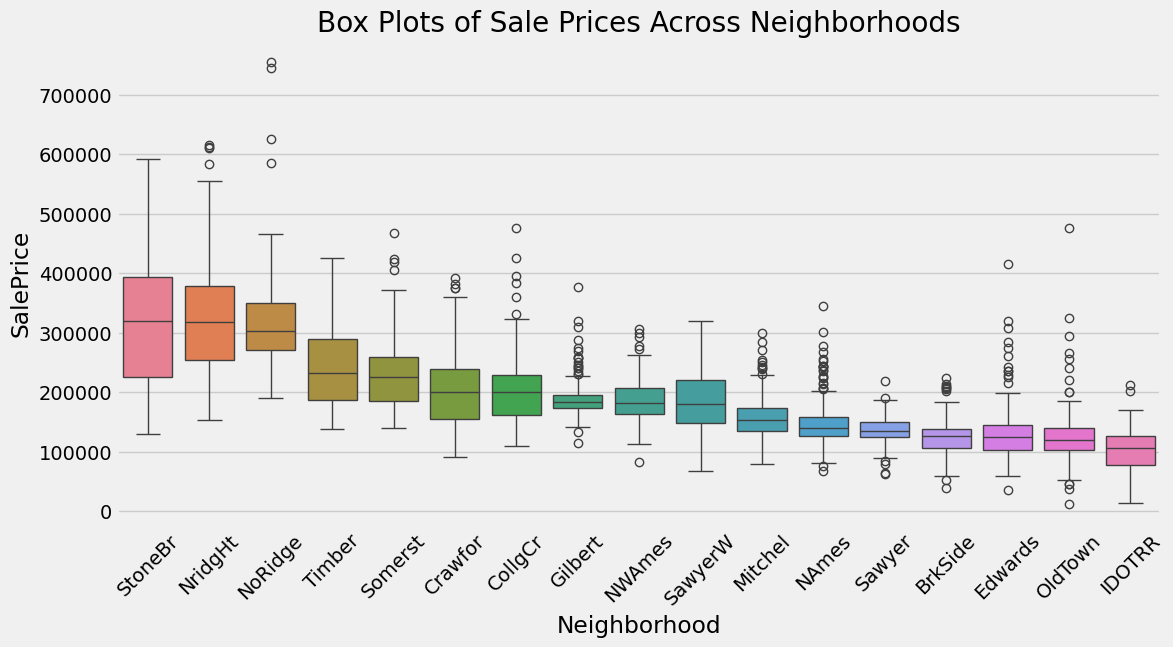

In [5]:
box_plots(ames)

**Question 3.1.** What do the circles in each of the box plots indicate? What do they tell us about the different neighborhoods?

*Your Answer Here*

### 3.2. Violin Plots

As previously noted, visual exploration is key to understanding whatever data is being analyzed. A violin plot is a great alternative to a box plot, as it provides additional insights into the shape of the data distribution. Unlike box plots, violin plots reveal more about the distribution shape and density of sale prices, making them useful for spotting multimodal distributions.

We use similar code to 3.1. to generate our plot defined by `violin_plots`.

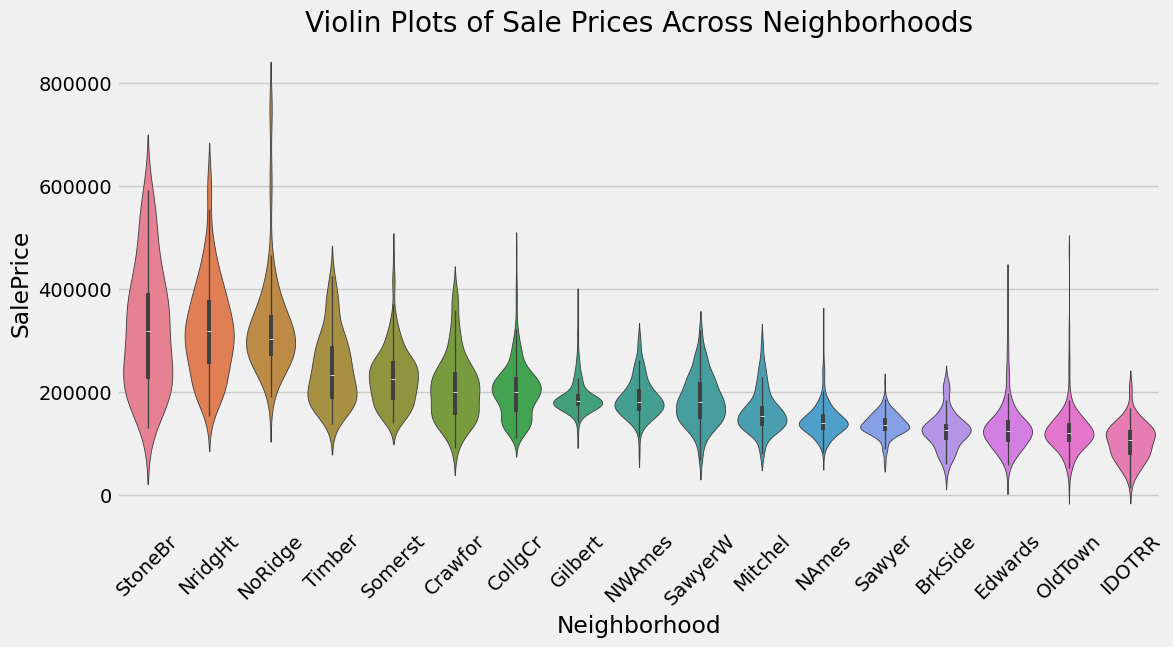

In [6]:
violin_plots(ames)

**Question 3.2.** Both box plots and violin plots show distribution, but what additional information does a violin plot provide that a box plot does not?

*Your Answer Here*

### 3.3 Histograms

Now that we have a good grasp of the distributions per neighborhood, let's take a step back and look at all of the sale prices in Ames. We can do this by plotting a histogram, which helps us understand the overall distribution of house prices across the entire dataset. We will be capable of identifying some key trends, such as whether house prices are skewed, where the most common price ranges are, and whether there are outliers in the dataset.

Our custom `histogram` function allows you to adjust the `bins` parameter dynamically using a slider! Try adjusting the slider below to change the number of bins and observe how it impacts the histogram.

In [7]:
histogram(ames)

interactive(children=(IntSlider(value=25, description='bins', max=50, min=5, step=5), Output()), _dom_classes=…

**Question 3.3.1.** What insights can we gain from looking at a histogram of house prices rather than just a single summary statistic like the mean or median?

*Your Answer Here*

**Question 3.3.2.** Looking at the histogram, do house prices appear to be normally distributed? If not, what type of skewness do you observe?

*Your Answer Here*

**Question 3.3.3.** When adjusting the slider, did increasing the bins reveal more details or make the visualization too noisy? What happens when you decrease the bins?

*Your Answer Here*

---

## 4. Performing ANOVA

Having cleaned and visualized the data, it is time to perform ANOVA! For this exercise, we will manually compute ANOVA in order to gain a deeper understanding of its components, in contrast to using a built-in function. There are 7 steps we want to follow:

### 4.1. Group Means and Overall Mean

Computing the mean sale prices for each neighborhood and the overall mean of sale prices.

In [8]:
group_means = ames.groupby("Neighborhood", observed=True)["SalePrice"].mean()
overall_mean = ames["SalePrice"].mean()

group_means[:3], overall_mean

(Neighborhood
 StoneBr    324229.196078
 NridgHt    322018.265060
 NoRidge    330319.126761
 Name: SalePrice, dtype: float64,
 182793.66504672897)

### 4.2. Between-Group Sum of Squares (SSB)

Computing the sum of squares between, or SSB.

In [9]:
ssb = sum(ames.groupby("Neighborhood", observed=True).size() * (group_means - overall_mean) ** 2)
ssb

9943483891966.02

### 4.3. Within-Group Sum of Squares (SSW)

Computing the sum of squares within, or SSW.

In [10]:
ssw = sum(sum((ames[ames["Neighborhood"] == group]["SalePrice"] - group_mean) ** 2)
          for group, group_mean in group_means.items())
ssw

7659972689149.87

### 4.4. Degrees of Freedom

Computing the degrees of freedom.

In [11]:
ames_between = len(group_means) - 1
ames_within = len(ames) - len(group_means)

print(f"{ames_between} {ames_within}")

16 2658


### 4.5. Mean Squares (MSB, MSW)

Computing the mean squares between (MSB) and mean squares within (MSW).

In [12]:
msb = ssb / ames_between
msw = ssw / ames_within

print(f"MSB: {msb}, MSW: {msw}")

MSB: 621467743247.8762, MSW: 2881855789.747882


### 4.6. F-Statistic

Computing the F-Statistic.

In [13]:
f_statistic = msb / msw
f_statistic

215.64845314561876

**Question 4.6.** What does a very large F-statistic indicate about the differences in sale prices between neighborhoods? What would a small F-statistic suggest?

*Your Answer Here*

### 4.7. p-value

Computing the p-value.

In [14]:
p_value = 1 - stats.f.cdf(f_statistic, ames_between, ames_within)
float(p_value)

1.1102230246251565e-16

**Question 4.7.** The computed p-value is extremely small. What does this tell us about the likelihood that all neighborhoods have the same average sale price? How should we interpret this result?

*Your Answer Here*

---

## 5. Sanity Check Using SciPy

Now that we have computed the F-statistic and p-value for ANOVA manually, let us use a pre-packaged function from `SciPy` called `f_oneway` to sanity check our results. 

Before we can instantly plug our data into `f_oneway`, there are a few steps we need to take to set up our input correctly. First, we initialize an empty list called `price_groups` to store sale prices per neighborhood. Next, we loop through `selected_neighborhoods`, filter the data to each neighborhood, and extract the sale prices for each one. Then, these extracted values are appended to `price_groups`, ultimately creating a list of `pd.Series`. Finally, we pass this list into `f_oneway`, using the unpacking operator `*` to so it inputs each `pd.Series` as a separate argument.

In [15]:
# Prepare SalePrice data for each neighborhood
price_groups = []
for neighborhood in selected_neighborhoods:
    ames_neighborhood = ames[ames["Neighborhood"] == neighborhood]
    price_group = ames_neighborhood["SalePrice"]
    price_groups.append(price_group)

# Run the One-Way ANOVA test
anova_result = stats.f_oneway(*price_groups)

print(f"Sanity Check - SciPy F-statistic: {anova_result.statistic:.2f}, p-value: {anova_result.pvalue:.5f}")

Sanity Check - SciPy F-statistic: 215.65, p-value: 0.00000


---

## 6. Penguins Sandbox

In [16]:
# Load the dataset
penguins = sns.load_dataset("penguins")
penguins = penguins.dropna()
penguins.head(10)

,species,island,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,sex
0,Adelie,Torgersen,39.1,18.7,181.0,3750.0,Male
1,Adelie,Torgersen,39.5,17.4,186.0,3800.0,Female
2,Adelie,Torgersen,40.3,18.0,195.0,3250.0,Female
4,Adelie,Torgersen,36.7,19.3,193.0,3450.0,Female
5,Adelie,Torgersen,39.3,20.6,190.0,3650.0,Male
6,Adelie,Torgersen,38.9,17.8,181.0,3625.0,Female
7,Adelie,Torgersen,39.2,19.6,195.0,4675.0,Male
12,Adelie,Torgersen,41.1,17.6,182.0,3200.0,Female
13,Adelie,Torgersen,38.6,21.2,191.0,3800.0,Male
14,Adelie,Torgersen,34.6,21.1,198.0,4400.0,Male


<Axes: xlabel='bill_length_mm', ylabel='Count'>

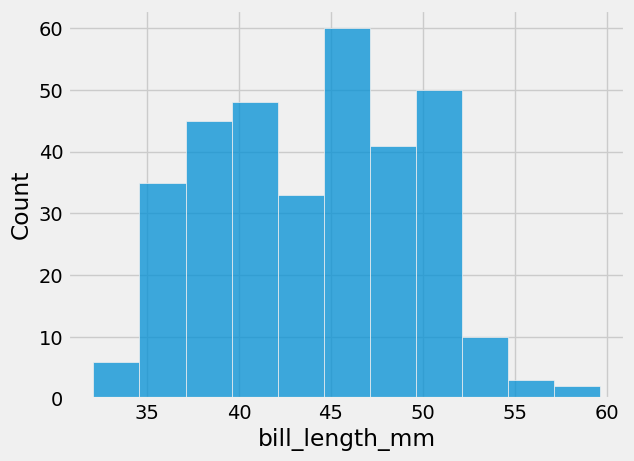

In [17]:
sns.histplot(data=penguins, x="bill_length_mm")

In [18]:
quant = penguins.columns.to_list()
quant.remove('species')
quant.remove('island')
quant.remove('sex')
quant

['bill_length_mm', 'bill_depth_mm', 'flipper_length_mm', 'body_mass_g']

<Figure size 1200x600 with 0 Axes>

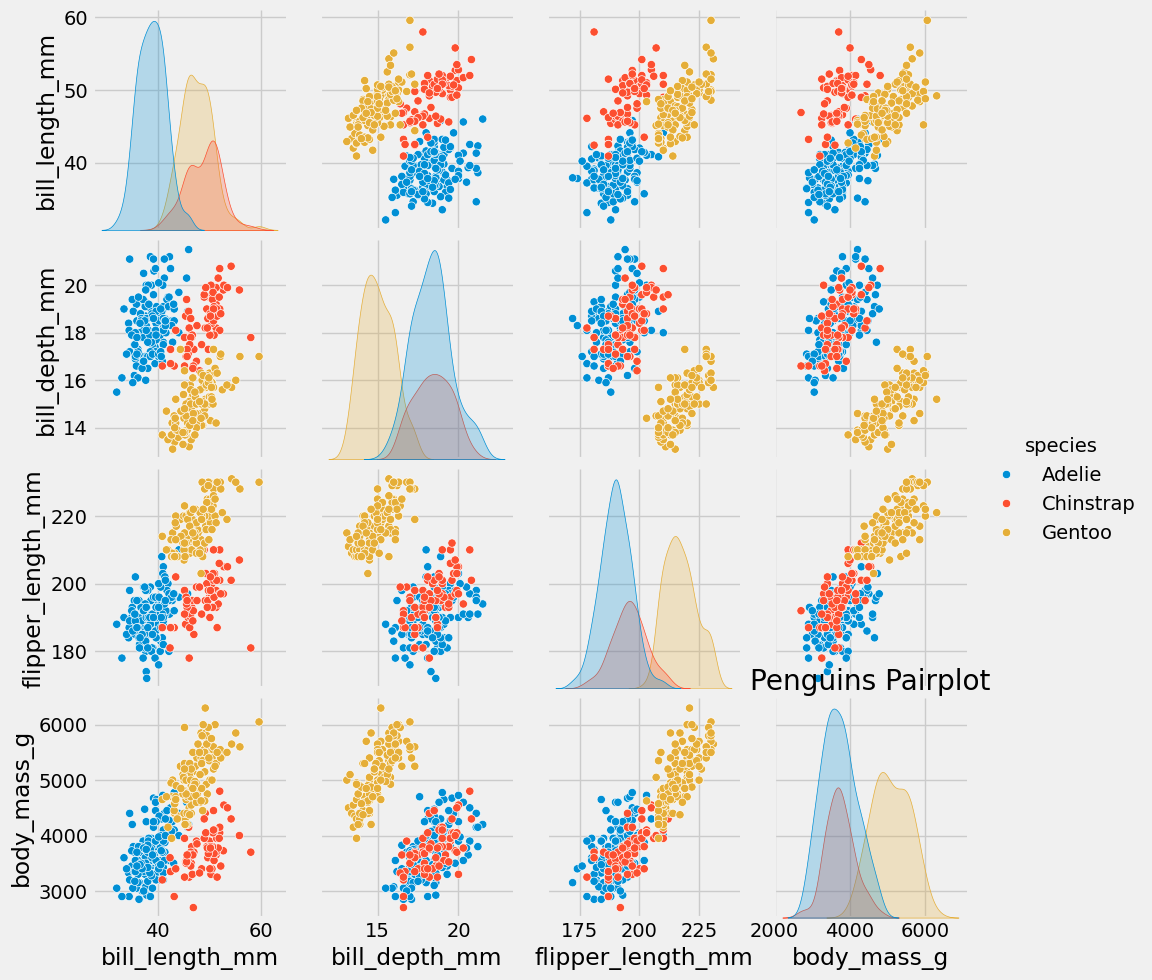

In [19]:
plt.figure(figsize=(12, 6))
sns.pairplot(penguins, vars=quant, hue='species', diag_kind="kde")
plt.xticks(rotation=45)
plt.title("Penguins Pairplot")
plt.show()

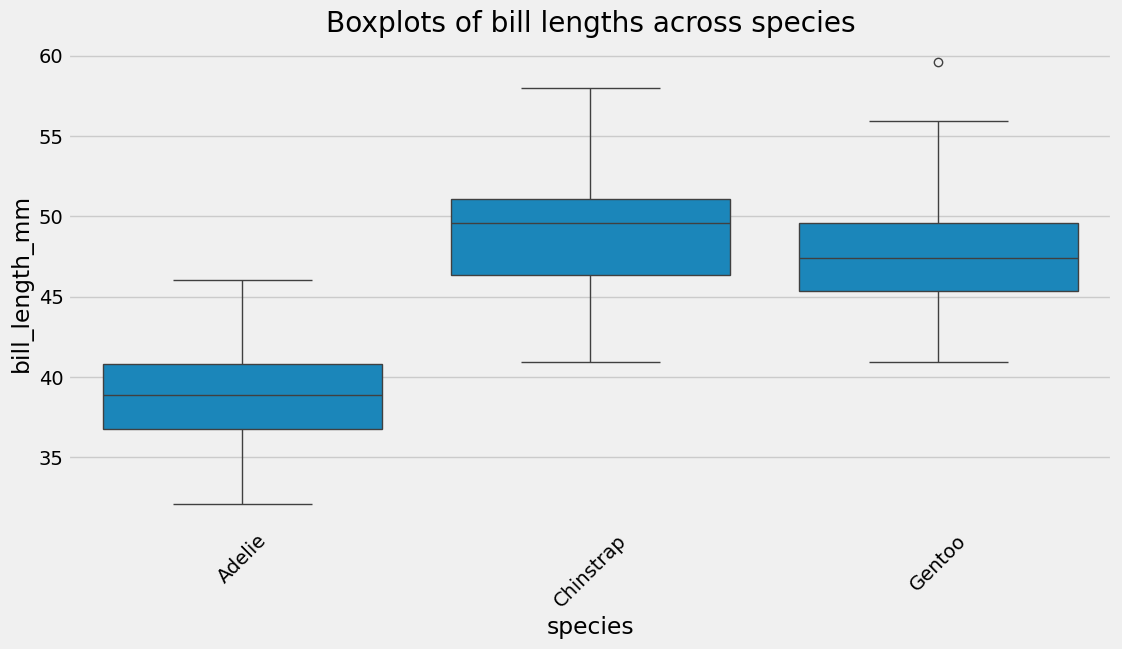

In [20]:
plt.figure(figsize=(12, 6))
sns.boxplot(data=penguins, x="species", y="bill_length_mm")
plt.xticks(rotation=45)
plt.title("Boxplots of bill lengths across species")
plt.show()

In [21]:
# Prepare bill_lengths data for each penguin species
bill_lengths = []
for species in penguins["species"].unique():
    penguins_species = penguins[penguins["species"] == species]
    bill_length_mm = penguins_species["bill_length_mm"]
    bill_lengths.append(bill_length_mm)

# Run the One-Way ANOVA test
anova_result = stats.f_oneway(*bill_lengths)

print(f"Sanity Check - SciPy F-statistic: {anova_result.statistic:.2f}, p-value: {anova_result.pvalue:.5f}")

Sanity Check - SciPy F-statistic: 397.30, p-value: 0.00000


---

## 7. Conclusion

In this notebook, we explored using ANOVA using the Ames housing and penguins datasets!

Note, however, that we should have more rigorously proved the ANOVA assumptions to be true at the start of the notebook, though this was abstracted away for the sake of this notebook. We highly encourage you to try proving these checks on your own, and you may find some interesting results!

We encourage you to explore further with the groundwork laid out with this notebook. You can try running ANOVA on different features and explore more tests to determine what neighborhoods had more signficant differences in sale price against other neighborhoods.

---

**Woohoo! You have completed this notebook! 🚀**